# Install & Import Dependencies

In [1]:
!pip install ipython-autotime -q
%load_ext autotime

time: 521 µs (started: 2025-03-13 20:17:28 +00:00)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import warnings
from transformers import BertTokenizer
import torch
from transformers import BertModel
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

time: 41.2 s (started: 2025-03-13 20:17:28 +00:00)


# Load Dataset

In [3]:
url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/spiill_reviews_preprocessed2.csv'
df_reviews = pd.read_csv(url)
df_reviews.tail(3)

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
5897,eiswahyudi,3,2024-03-17,non,neutral,Pasar saham Indonesia menunjukkan tren yang st...,Masker Skintific,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,pasar saham indonesia menunjukkan tren yang st...,"['pasar', 'saham', 'indonesia', 'menunjukkan',...","['pasar', 'saham', 'indonesia', 'tren', 'stabil']","['pasar', 'saham', 'indonesia', 'tren', 'stabil']","['pasar', 'saham', 'indonesia', 'tren', 'stabil']"
5898,dkusumo,5,2023-09-18,non,neutral,Penggunaan kendaraan listrik mulai diminati di...,Masker Skintific,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,penggunaan kendaraan listrik mulai diminati di...,"['penggunaan', 'kendaraan', 'listrik', 'mulai'...","['penggunaan', 'kendaraan', 'listrik', 'dimina...","['penggunaan', 'kendaraan', 'listrik', 'dimina...","['guna', 'kendara', 'listrik', 'mati', 'kota']"
5899,adisti,3,2023-09-11,non,neutral,Lumayan lancar dengan berjalan baik,Masker Skintific,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,lumayan lancar dengan berjalan baik,"['lumayan', 'lancar', 'dengan', 'berjalan', 'b...","['lumayan', 'lancar', 'berjalan']","['lumayan', 'lancar', 'berjalan']","['lumayan', 'lancar', 'jalan']"


time: 865 ms (started: 2025-03-13 20:18:40 +00:00)


In [4]:
df_reviews.sentimen.value_counts()

sentimen
positive    3686
neutral     1352
negative     862
Name: count, dtype: int64

time: 8.15 ms (started: 2025-03-13 20:19:06 +00:00)


In [5]:
df_reviews.label.value_counts()

label
trusted    3912
non        1150
fake        838
Name: count, dtype: int64

time: 3.83 ms (started: 2025-03-13 20:19:06 +00:00)


In [8]:
df_reviews.dtypes

 username                        object
rate                              int64
date                             object
label                            object
sentimen                         object
reviews                          object
produk                           object
no_link_hashtag_reviews          object
no_emojis_reviews                object
no_html_reviews                  object
no_special_char_reviews          object
no_number_reviews                object
no_punct_reviews                 object
no_whitespace_reviews_reviews    object
lowercase_reviews                object
tokens_reviews                   object
no_stopwords_reviews             object
normalized_reviews               object
stemmed_reviews                  object
dtype: object

time: 4 ms (started: 2025-03-13 20:19:42 +00:00)


# Modeling

## Model Function Preparation

In [9]:
# Preprocessing and Model Preparation
class IndoBERTMultiTaskClassifier:
    def __init__(self, model_name='indobenchmark/indobert-base-p1'):
        """
        Initialize IndoBERT Tokenizer and Prepare Multi-Task Model
        """
        # Load pre-trained IndoBERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Prepare label encoders
        self.sentiment_encoder = LabelEncoder()
        self.label_encoder = LabelEncoder()
        
    def prepare_data(self, df):
        """
        Prepare data for model training
        """
        # Prepare sentiment labels
        y_sentiment = self.sentiment_encoder.fit_transform(df['sentimen'])
        y_label = self.label_encoder.fit_transform(df['label'])
        
        # Tokenize texts
        encodings = self.tokenizer(
            df['stemmed_reviews'].tolist(), 
            truncation=True, 
            padding=True, 
            max_length=128,
            return_tensors='tf'
        )
        
        # Convert to categorical
        y_sentiment_cat = tf.keras.utils.to_categorical(y_sentiment)
        y_label_cat = tf.keras.utils.to_categorical(y_label)
        
        return encodings, y_sentiment_cat, y_label_cat
    
    def create_multitask_model(self, num_sentiment_classes, num_label_classes):
        """
        Create multi-task classification model using IndoBERT
        """
        # Input layers
        input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
        
        # Use TFAutoModelForSequenceClassification as the base
        base_model = TFAutoModelForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1', 
            num_labels=num_sentiment_classes  # This is just a placeholder
        )
        
        # Get the base transformer layers
        transformer_layers = base_model.layers[0]
        
        # Run the transformer layers
        transformer_output = transformer_layers(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            return_dict=False
        )[0]
        
        # Add custom classification layers
        x = tf.keras.layers.GlobalMaxPooling1D()(transformer_output)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        # Multi-task output layers
        sentiment_output = tf.keras.layers.Dense(
            num_sentiment_classes, 
            activation='softmax', 
            name='sentiment'
        )(x)
        label_output = tf.keras.layers.Dense(
            num_label_classes, 
            activation='softmax', 
            name='label'
        )(x)
        
        # Create model
        model = tf.keras.Model(
            inputs=[input_ids, attention_mask],
            outputs=[sentiment_output, label_output]
        )
        
        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
            loss={
                'sentiment': 'categorical_crossentropy',
                'label': 'categorical_crossentropy'
            },
            metrics={
                'sentiment': 'accuracy',
                'label': 'accuracy'
            }
        )
    
        return model
    
    def train_model(self, df, test_size=0.2, random_state=42):
        """
        Train the multi-task IndoBERT model
        """
        # Prepare data
        encodings, y_sentiment, y_label = self.prepare_data(df)
        
        # Convert TensorFlow tensors to NumPy arrays for splitting
        X_ids = encodings['input_ids'].numpy()
        X_mask = encodings['attention_mask'].numpy()
        
        # Split data
        X_train_ids, X_test_ids, X_train_mask, X_test_mask, \
        y_sentiment_train, y_sentiment_test, \
        y_label_train, y_label_test = train_test_split(
            X_ids, 
            X_mask,
            y_sentiment, 
            y_label, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Convert back to TensorFlow tensors
        X_train_ids = tf.convert_to_tensor(X_train_ids, dtype=tf.int32)
        X_test_ids = tf.convert_to_tensor(X_test_ids, dtype=tf.int32)
        X_train_mask = tf.convert_to_tensor(X_train_mask, dtype=tf.int32)
        X_test_mask = tf.convert_to_tensor(X_test_mask, dtype=tf.int32)
        
        # Create model
        model = self.create_multitask_model(
            num_sentiment_classes=y_sentiment.shape[1],
            num_label_classes=y_label.shape[1]
        )
        
        # Define callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train model
        history = model.fit(
            {
                'input_ids': X_train_ids, 
                'attention_mask': X_train_mask
            },
            {
                'sentiment': y_sentiment_train,
                'label': y_label_train
            },
            validation_data=(
                {
                    'input_ids': X_test_ids, 
                    'attention_mask': X_test_mask
                },
                {
                    'sentiment': y_sentiment_test,
                    'label': y_label_test
                }
            ),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping]
        )
        
        return (
            model, 
            history, 
            X_test_ids, 
            X_test_mask, 
            y_sentiment_test, 
            y_label_test
        )
        
    def evaluate_model(self, model, X_test_ids, X_test_mask, y_sentiment_test, y_label_test):
        """
        Evaluate the model and generate classification reports and confusion matrices
        """
        # Predict
        sentiment_pred, label_pred = model.predict({
            'input_ids': X_test_ids,
            'attention_mask': X_test_mask
        })
        
        # Convert predictions to classes
        sentiment_pred_classes = np.argmax(sentiment_pred, axis=1)
        label_pred_classes = np.argmax(label_pred, axis=1)
        
        sentiment_true_classes = np.argmax(y_sentiment_test, axis=1)
        label_true_classes = np.argmax(y_label_test, axis=1)
        
        # Get original class names
        sentiment_classes = self.sentiment_encoder.classes_
        label_classes = self.label_encoder.classes_
        
        # Print Classification Reports
        print("\nSentiment Classification Report:")
        print(classification_report(
            sentiment_true_classes, 
            sentiment_pred_classes, 
            target_names=sentiment_classes
        ))
        
        print("\nLabel Classification Report:")
        print(classification_report(
            label_true_classes, 
            label_pred_classes, 
            target_names=label_classes
        ))
        
        # Confusion Matrices
        def plot_confusion_matrix(true_classes, pred_classes, classes, title):
            cm = confusion_matrix(true_classes, pred_classes)
            plt.figure(figsize=(8, 6))
            sns.heatmap(
                cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=classes, 
                yticklabels=classes
            )
            plt.title(title)
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()
        
        # Plot Confusion Matrices
        plot_confusion_matrix(
            sentiment_true_classes, 
            sentiment_pred_classes, 
            sentiment_classes, 
            'Sentiment Confusion Matrix'
        )
        plot_confusion_matrix(
            label_true_classes, 
            label_pred_classes, 
            label_classes, 
            'Label Confusion Matrix'
        )
        
        return {
            'sentiment_report': classification_report(
                sentiment_true_classes, 
                sentiment_pred_classes, 
                target_names=sentiment_classes, 
                output_dict=True
            ),
            'label_report': classification_report(
                label_true_classes, 
                label_pred_classes, 
                target_names=label_classes, 
                output_dict=True
            ),
            'sentiment_cm': confusion_matrix(sentiment_true_classes, sentiment_pred_classes),
            'label_cm': confusion_matrix(label_true_classes, label_pred_classes)
        }
    
    def predict_text(self, text, model):
        """
        Predict sentiment and label for a given text
        """
        # Tokenize input text
        encoding = self.tokenizer(
            text, 
            truncation=True, 
            padding=True, 
            max_length=128,
            return_tensors='tf'
        )
        
        # Make prediction
        sentiment_pred, label_pred = model.predict({
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask']
        })
        
        # Convert predictions to classes
        sentiment = self.sentiment_encoder.inverse_transform([np.argmax(sentiment_pred[0])])[0]
        label = self.label_encoder.inverse_transform([np.argmax(label_pred[0])])[0]
        
        return sentiment, label

time: 2.9 ms (started: 2025-03-13 20:19:42 +00:00)


## Train Model

In [12]:
# Initialize IndoBERT Multi-Task Classifier
classifier = IndoBERTMultiTaskClassifier()

# Train the model
(model, history, X_test_ids, X_test_mask, y_sentiment_test, y_label_test) = classifier.train_model(df_reviews)

NameError: name 'AutoTokenizer' is not defined

time: 39.9 ms (started: 2025-03-13 20:20:21 +00:00)


## Training History

NameError: name 'history' is not defined

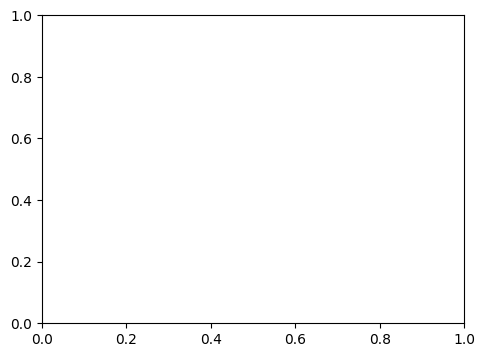

time: 219 ms (started: 2025-03-13 20:19:42 +00:00)


In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sentiment_accuracy'], label='sentiment_accuracy')
plt.plot(history.history['val_sentiment_accuracy'], label='val_sentiment_accuracy')
plt.title('Sentiment Accuracy (IndoBERT)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['label_accuracy'], label='label_accuracy')
plt.plot(history.history['val_label_accuracy'], label='val_label_accuracy')
plt.title('Label Accuracy (IndoBERT)')
plt.legend()
plt.show()

## Evaluate Model Performance

In [ ]:
# Evaluate the model
results = classifier.evaluate_model(
        model, 
        X_test_ids, 
        X_test_mask, 
        y_sentiment_test, 
        y_label_test
    )

## Try Predictions

In [ ]:
test_text = "Sayangnya pengiriman lebih lambat dari jadwal. Produk tetap sampai dengan baik, tetapi semoga pengiriman bisa lebih cepat di masa depan."
sentiment, label = classifier.predict_text(test_text, model)
print(f"\nPrediction for test text:")
print(f"Sentiment: {sentiment}")
print(f"Label: {label}")

# WordCloud

## Positive

In [ ]:
df_reviews.head(1)

In [ ]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='positive']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nPOSITIVE\n')

## Neutral

In [ ]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='neutral']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEUTRAL\n')

## Negative

In [ ]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='negative']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEGATIVE\n')

In [ ]:
df_reviews.label.unique()

## Trusted

In [ ]:
word_list = []
for text in df_reviews[df_reviews['label']=='trusted']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nTRUSTED\n')

## Non

In [ ]:
word_list = []
for text in df_reviews[df_reviews['label']=='non']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')

## Fake

In [ ]:
word_list = []
for text in df_reviews[df_reviews['label']=='fake']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')